### Common imports

In [1]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
from IPython.display import display

In [2]:
import sys
import os

sys.path.insert(0, "/home/giuseppe/catkin_ws/src/sampling_based_control/mppi/python")
import numpy as np
import matplotlib.pyplot as plt
import pymppi as pys
import time

fig, axb = plt.subplots()
n = 3
t = np.arange(-n, 5+n, 1).astype(np.float64)
x = np.linspace(t[0], t[-1], 1000)
for i in range(t.size-n-1):
    start = time.time()
    y = pys.B(x, n, i, t)
    end = time.time()

    print(end - start)
    axb.plot(x, y)

# Test policy
cfg = pys.BSplinePolicyConfig()
cfg.verbose = True
cfg.dt = 0.01
cfg.max_value = 1
cfg.min_value = -1
cfg.sigma = 1.0

policy = pys.RecedingHorizonSpline(cfg)
y = policy.compute_nominal()
t = policy.get_time()

fig, ax = plt.subplots()
ax.plot(t, y, label="policy")
ax.plot(policy.control_polygon_t(), policy.control_polygon_y(), 'o--', label="control polygon")
ax.grid()
ax.legend()
plt.show()

ImportError: libclass_loader.so: cannot open shared object file: No such file or directory

### Shift operation
TODO(giuseppe) cpp implementation still plotting untile the very last cpoint which is wrong when shifting back and t shift is less then dtcp

<IPython.core.display.Javascript object>


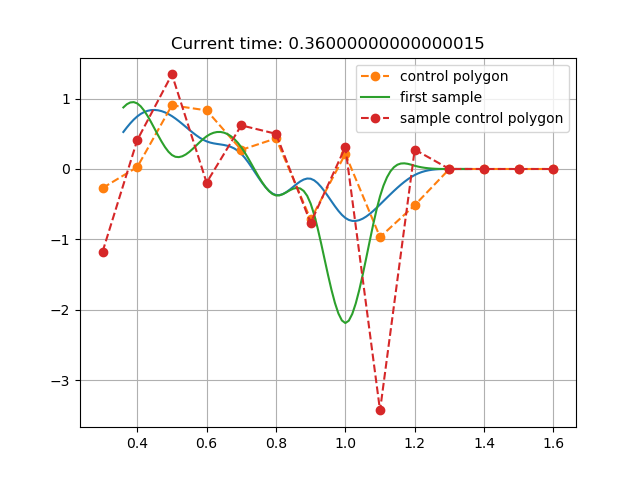

Button(description='shift', style=ButtonStyle())

In [3]:
t0 = 0.0
dt = 0.01

fig2, ax2 = plt.subplots()
y = policy.compute_nominal()
ys = policy.get_samples()
t = policy.get_time()
ax2.plot(t, y)
ax2.plot(policy.control_polygon_t(), policy.control_polygon_y(), 'o--', label="control polygon")
ax2.plot(t, ys[:, 0], label="first sample")
ax2.plot(policy.control_polygon_t(), 
         policy.get_sample_control_polygon(0), 'o--', label="sample control polygon")
ax2.set_title(f"Current time: {t0}")
ax2.grid()
ax2.legend()

#print(f"Control polygon:\n t={policy.control_polygon_t()}\n y={policy.control_polygon_y()}")

def shift_policy(b):
    # Clear previous plot
    global ax2
    global t0
    global dt
    
    ax2.clear()
    t0 += dt
    policy.shift(t0)
      
    
    y = policy.compute_nominal()
    ys = policy.get_samples()
    t = policy.get_time()
    ax2.plot(t, y)
    ax2.plot(policy.control_polygon_t(), policy.control_polygon_y(), 'o--', label="control polygon")
    ax2.plot(t, ys[:, 0], label="first sample")
    ax2.plot(policy.control_polygon_t(), 
         policy.get_sample_control_polygon(0), 'o--', label="sample control polygon")
    ax2.set_title(f"Current time: {t0}")
    ax2.grid()
    ax2.legend()
    plt.show()
    
button = widgets.Button(description="shift")
button.on_click(shift_policy)
display(button)

### Sampling multiple trajectories at once

Samples have shape: (101, 10)
Sampling took: 0.05745887756347656 ms
Computing gradients took: 0.3380775451660156 ms
Computing gradients matrix took: 0.12874603271484375 ms
Gradient matrix has shape: (101, 14)


<IPython.core.display.Javascript object>


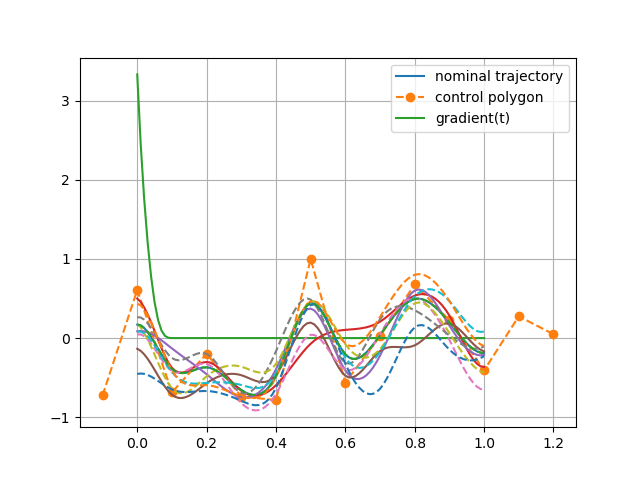

interactive(children=(IntSlider(value=6, description='control_point', max=13), IntSlider(value=4, description=…

Button(description='update samples', style=ButtonStyle())

In [4]:
cfg2 = pys.BSplinePolicyConfig()
cfg2.dt = 0.01
cfg2.cp_dt = 0.1
cfg2.max_value = 1
cfg2.min_value = -1
cfg2.sigma = 0.1
policy2 = pys.RecedingHorizonSpline(cfg2)

tic = time.time()
ys = policy2.get_samples()
toc = time.time()
print(f"Samples have shape: {ys.shape}")
print(f"Sampling took: {(toc-tic)*1e3} ms")

tic = time.time()
g = policy2.get_gradients()
toc = time.time()
print(f"Computing gradients took: {(toc-tic)*1e3} ms")

tic = time.time()
G = policy2.get_gradients_matrix()
toc = time.time()
print(f"Computing gradients matrix took: {(toc-tic)*1e3} ms")
print(f"Gradient matrix has shape: {G.shape}")

figs, axs = plt.subplots()
yn = policy2.compute_nominal()
tn = policy2.get_time()

axs.plot(tn, yn, label="nominal trajectory")
axs.plot(policy2.control_polygon_t(), policy2.control_polygon_y(), 'o--', label="control polygon")
  

# which are the best samples 
weights = np.zeros([ys.shape[1]])
weights[:3] = np.ones(3)

@widgets.interact(control_point=(0, g.shape[1]-1, 1), sample=(0, ys.shape[1]-1, 1), show_all=False)
def show_samples(control_point, sample, show_all):
    # Clear previous plot
    global axs
    axs.clear()
      
    axs.plot(tn, yn, label="nominal trajectory")
    axs.plot(policy2.control_polygon_t(), policy2.control_polygon_y(), 'o--', label="control polygon")

    axs.plot(tn, G[:, control_point], label="gradient(t)")
    
    if not show_all:
        axs.plot(tn, ys[:, sample], label="perturbed trajectory")
    else:
        for i, w in enumerate(weights):
            if w == 0:
                axs.plot(tn, ys[:, i], '--')
            else:
                axs.plot(tn, ys[:, i])
        
    axs.grid()
    axs.legend()
    plt.show()

def update_samples(btn):
    global ys
    
    policy2.update_samples(weights, 3)
    ys = policy2.get_samples()
    show_samples(0, 0, True)
    
    
update_samples_button = widgets.Button(description="update samples")
update_samples_button.on_click(update_samples)
display(update_samples_button)    

### Test update 
We sample policies once and then we repedetly update the policy keeping weight 1 to only one sample and 0 to the rest. We should observe the policy converging to the policy of the sample

<IPython.core.display.Javascript object>


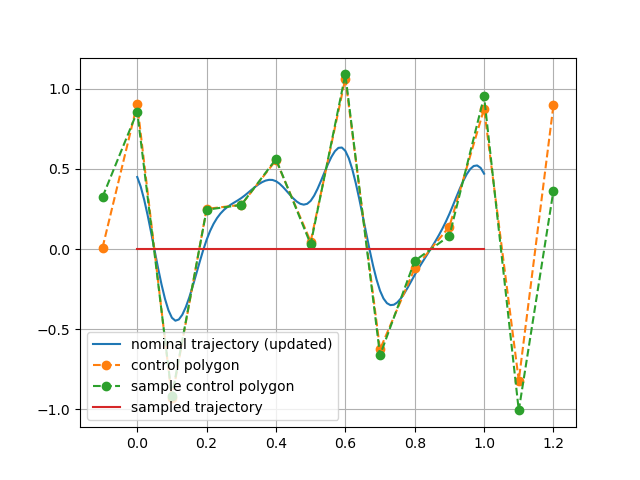

In [5]:
cfg3 = pys.BSplinePolicyConfig()
cfg3.dt = 0.01
cfg3.cp_dt = 0.1
cfg3.max_value = 1
cfg3.min_value = -1
cfg3.sigma = 0.1
policy3 = pys.RecedingHorizonSpline(cfg3)

chosen_sample = 3
ys = policy3.get_samples()
ws = np.zeros(ys.shape[1]) # as many weights as the number of samples
ws[chosen_sample] = 1.0

figu, axu = plt.subplots()
yn = policy3.compute_nominal()
tn = policy3.get_time()

axu.plot(tn, yn, label="nominal trajectory")
axu.plot(policy3.control_polygon_t(), policy3.control_polygon_y(), 'o--', label="control polygon")
axu.plot(tn, ys[:, chosen_sample], label="sampled trajectory")
axu.plot(policy3.control_polygon_t(), 
             policy3.get_sample_control_polygon(chosen_sample), 'o--', label="sample control polygon")
axu.grid()

def update_policy(b):
    # Clear previous plot
    global axu
    axu.clear()
    policy3.update(ws, 0.01)
    t = policy3.get_time()
    y = policy3.compute_nominal()
    ys = policy3.get_samples()
    axu.plot(t, y, label='nominal trajectory (updated)')
    axu.plot(policy3.control_polygon_t(), policy3.control_polygon_y(), 'o--', label="control polygon")
    axu.plot(policy3.control_polygon_t(), 
             policy3.get_sample_control_polygon(chosen_sample), 'o--', label="sample control polygon")
    axu.plot(t, ys[:, chosen_sample], label="sampled trajectory")
    axu.legend()
    axu.grid()
    plt.show()

    
t0 = 0.0
dt = 0.01

def shift_policy2(b):
    # Clear previous plot
    global axu
    global t0
    global dt
    
    axu.clear()
    t0 += dt
    policy3.shift(t0)
      
    
    y = policy3.compute_nominal()
    ys = policy3.get_samples()
    t = policy3.get_time()
    axu.plot(t, y, label='nominal trajectory (updated)')
    axu.plot(policy3.control_polygon_t(), policy3.control_polygon_y(), 'o--', label="control polygon")
    axu.plot(policy3.control_polygon_t(), 
             policy3.get_sample_control_polygon(chosen_sample), 'o--', label="sample control polygon")
    axu.plot(t, ys[:, chosen_sample], label="sampled trajectory")
    axu.legend()
    axu.grid()
    plt.show()
    
update_button = widgets.Button(description="update")
update_button.on_click(update_policy)

shift_button = widgets.Button(description="shift")
shift_button.on_click(shift_policy2)

buttons = widgets.HBox([update_button, shift_button])
display(buttons)